## 1. Importing Dependencies

In [2]:
import pandas as pd
import numpy as np
import sklearn 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import learning_curve 
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from feature_engine.datetime import DatetimeFeatures
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

import joblib
import matplotlib.pyplot as plt

In [3]:
pd.set_option("display.max_columns",None)
sklearn.set_config(transform_output="default")

## Getting data

In [4]:
train_df=pd.read_csv("data/train.csv")
val_df=pd.read_csv("data/val.csv")
test_df=pd.read_csv("data/test.csv")

In [5]:
train_df

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187
...,...,...,...,...,...,...,...,...,...,...
635,Air Asia,2019-04-12,Banglore,Delhi,04:55:00,07:45:00,170,0.0,No Info,4282
636,Jet Airways,2019-05-09,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info,13067
637,Indigo,2019-05-15,Banglore,Delhi,06:05:00,08:50:00,165,0.0,No Info,4423
638,Multiple Carriers,2019-05-15,Delhi,Cochin,08:45:00,21:00:00,735,1.0,No Info,7670


### 3.1 Splitting Data

In [6]:
def split_data(df):
    x=df.drop(columns="price")
    y=df.price.copy()
    return x,y

In [7]:
X_train,y_train=split_data(train_df)

In [8]:
X_train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info
...,...,...,...,...,...,...,...,...,...
635,Air Asia,2019-04-12,Banglore,Delhi,04:55:00,07:45:00,170,0.0,No Info
636,Jet Airways,2019-05-09,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info
637,Indigo,2019-05-15,Banglore,Delhi,06:05:00,08:50:00,165,0.0,No Info
638,Multiple Carriers,2019-05-15,Delhi,Cochin,08:45:00,21:00:00,735,1.0,No Info


In [9]:
y_train


0       4995
1       8372
2       6117
3       7770
4       9187
       ...  
635     4282
636    13067
637     4423
638     7670
639    10844
Name: price, Length: 640, dtype: int64

In [10]:
X_val,y_val=split_data(val_df)
X_test,y_test=split_data(val_df)


### 3.2 Meta-info

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


## Preprocessing 

In [12]:
num=["duration","total_stops"]
dt_type=["date_of_journey","dep_time","arrival_time"]
obj=[col for col in X_train.columns if col  not in num and col  not in dt_type]

In [13]:
num_pipe= Pipeline(steps=[
    ("Imputer", SimpleImputer(strategy="median")),
    ("Scaler", StandardScaler()),
]) 

cat_pipe=Pipeline(steps=[
    ("Imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
])

doj_pipe=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["month","week","day_of_week","day_of_month"], format="mixed")),
    ("Scaler",StandardScaler())
])

time_pipe=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["hour","minute"], format="mixed")),
    ("Scaler",StandardScaler())
])





In [14]:
preprocessor= ColumnTransformer(transformers=[
    ("num",num_pipe,num),
    ("cat",cat_pipe,obj),
    ("doj",doj_pipe,['date_of_journey']),
    ("time",time_pipe,["dep_time","arrival_time"])
])

In [15]:
preprocessor.fit_transform(X_train)

array([[-1.09591823, -1.21213152,  0.        , ..., -0.14005709,
        -0.34523131,  1.49385907],
       [ 1.43569944,  0.31797533,  0.        , ..., -1.22986299,
        -0.93560684,  0.89104078],
       [ 1.82441239,  1.84808218,  0.        , ..., -0.68496004,
        -0.34523131, -1.21882323],
       ...,
       [-0.94641325, -1.21213152,  0.        , ..., -0.95741152,
        -0.78801296,  1.49385907],
       [ 0.18982461,  0.31797533,  0.        , ...,  1.22220029,
         1.1307075 , -1.52023237],
       [ 0.63833955,  0.31797533,  0.        , ..., -1.22986299,
        -0.19763743, -1.52023237]])

In [16]:
data = pd.concat([train_df,val_df], axis=0)
Big_X, Big_y= split_data(data)

In [17]:
Big_X.shape

(800, 9)

In [18]:
algorithms= {
    "Linear Regression": LinearRegression(),
    "Support Vector Regression": SVR(),
    "Random forest": RandomForestRegressor(n_estimators=10),
    "XG Boost": XGBRegressor(n_estimators=10),
}


In [19]:
def plot_curves(sizes , mean_scores, std_scores, ax, label):
    ax.plot(
        sizes,
        mean_scores,
        marker='o',
        label=label
    )

    ax.fill_between(
        x=sizes,
        y1=mean_scores- std_scores,
        y2= mean_scores+ std_scores,
        alpha = 0.5
        
    )

In [20]:
def plot_learning_curve(name , algorithm , figsize=(12,4)):
    model = Pipeline(steps=[
        ("pre", preprocessor),
        ("alg", algorithm)
    ])

    train_sizes , train_scores, test_scores = learning_curve(
        estimator=model,
        X=Big_X,
        y=Big_y,
        cv=3,
        scoring="r2",
        n_jobs=-1,
        random_state=42
    )

    mean_train_scores= np.mean(train_scores, axis=1)
    std_train_scores=np.std(train_scores, axis=1)
    train_score= f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"
    
    mean_test_scores= np.mean(test_scores, axis=1)
    std_test_scores=np.std(test_scores, axis=1)
    test_score= f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"


    fig,ax = plt.subplots(figsize=figsize)
    
    plot_curves(
        train_sizes,
        mean_train_scores,
        std_train_scores,
        ax,
        f"Train {train_score}"
    )
    plot_curves(
        train_sizes,
        mean_test_scores,
        std_test_scores,
        ax,
        f"Test {test_score}"
    )

    ax.set(xlabel= 'Training Set Size', ylabel= 'R2 score', title= name)

    ax.legend(loc='lower right')
    plt.show()

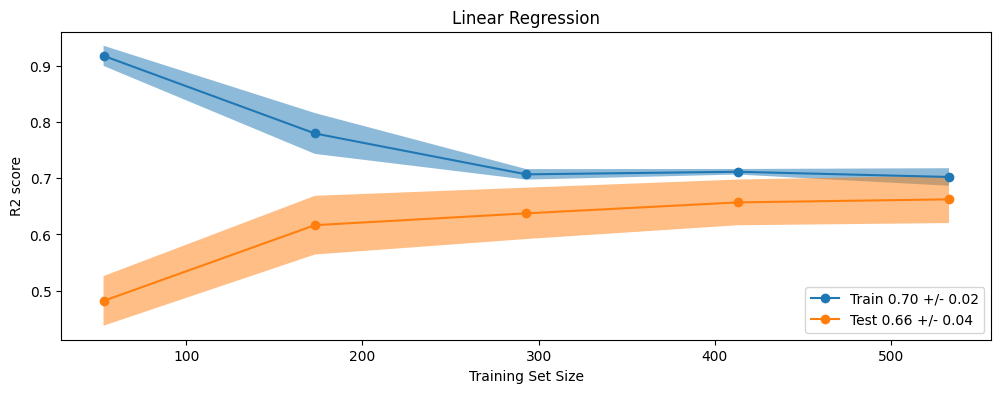

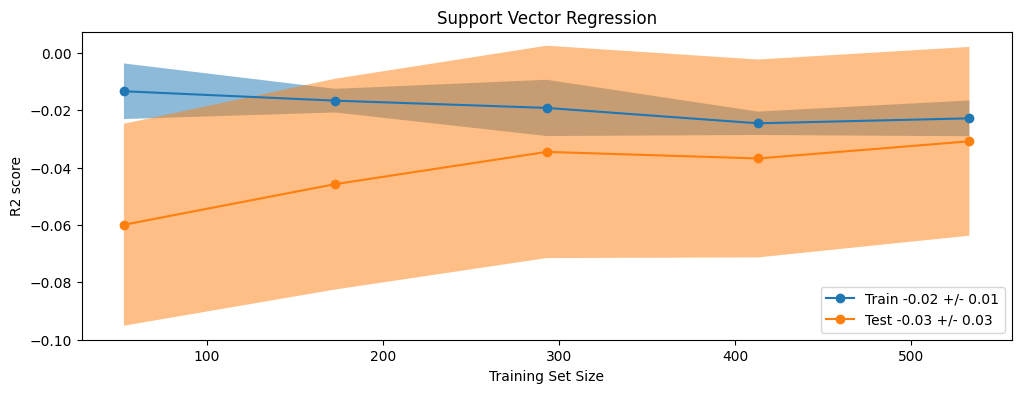

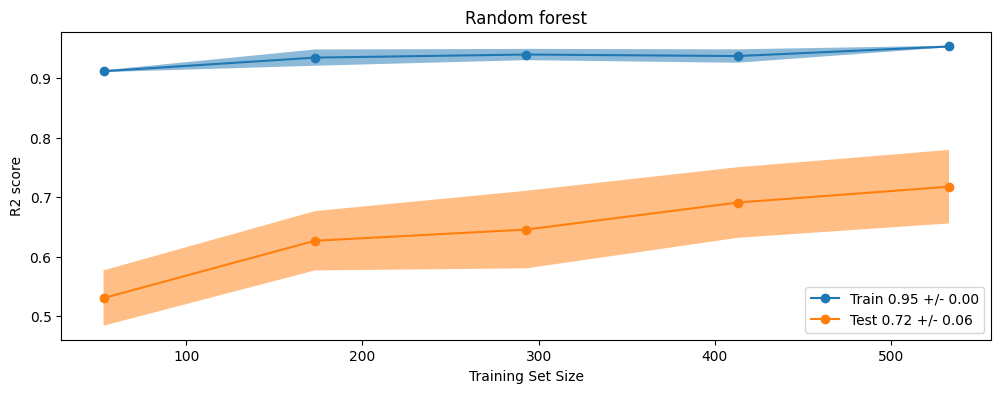

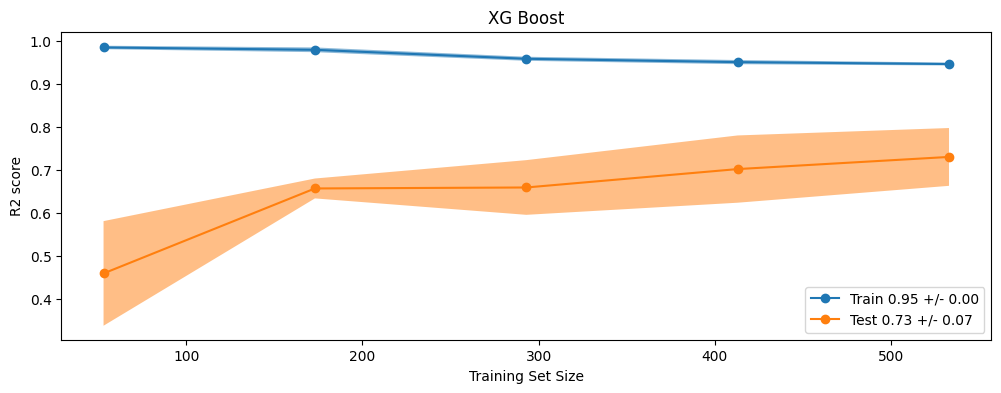

In [21]:
for name , alg in algorithms.items():
    plot_learning_curve(name, alg)

## Model Training

In [22]:
model= Pipeline(steps=[
    ("pre", preprocessor),
    ("rf", RandomForestRegressor())
]) 

In [23]:
model.fit(Big_X,Big_y)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_week',
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor())])

### Model Evaluation

In [24]:
def evaluate_model(X,y):
    y_pred=model.predict(X)
    return r2_score(y,y_pred)

In [25]:
print(f"On train data {evaluate_model(Big_X,Big_y)}")

On train data 0.965234023377409


In [26]:
print(f"On test data {evaluate_model(X_test,y_test)}")

On test data 0.9712615461852016


## Model Persistence

In [27]:
joblib.dump(model, "model.joblib")

['model.joblib']

In [28]:
saved_model=joblib.load('model.joblib')

In [29]:
y_pred=saved_model.predict(X_test)
r2_score(y_test,y_pred)

0.9712615461852016